https://www.kaggle.com/me/account

In [1]:
from google.colab import files # чтобы загружать файлы в облако через проводник
uploaded = files.upload() #просто запускаем и выбираем файл  API токена в проводнике

#↓ строка которая активирует наш API токен
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#↓ добавился восклицательный знак, потому что это колаб
!kaggle competitions download -c urfuaieng2022reg2

 78% 33.0M/42.1M [00:01<00:00, 33.9MB/s]
100% 42.1M/42.1M [00:01<00:00, 40.0MB/s]


https://www.kaggle.com/competitions/urfuaieng2022reg2/data

In [3]:
#↓ "распакуй" + имя архива
!unzip urfuaieng2022reg2.zip

Archive:  urfuaieng2022reg2.zip
  inflating: Submission_reg.csv      
  inflating: Test_Who.csv            
  inflating: Train_Target_reg.csv    
  inflating: Train_Who.csv           
  inflating: assessments.csv         
  inflating: courses.csv             
  inflating: studentAssessment.csv   
  inflating: studentInfo.csv         
  inflating: studentRegistration.csv  
  inflating: studentVle.csv          
  inflating: vle.csv                 


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
# альтернативно можно использовать StratifiedKFold т.к. задача классификации
import seaborn as sns # чтобы подкрасить таблички

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)


## Некоторые полезные функции для анализа табличек между собой

# Загружаем данные в Pandas

In [5]:
# данные которые "все"
ass = pd.read_csv('/content/assessments.csv')
courses = pd.read_csv('/content/courses.csv')
results = pd.read_csv('/content/studentAssessment.csv')
info = pd.read_csv('/content/studentInfo.csv')
reg = pd.read_csv('/content/studentRegistration.csv')
vle = pd.read_csv('/content/studentVle.csv')
materials = pd.read_csv('/content/vle.csv')

## Assessments info (информация об оценках)

1. **code_module** – идентификационный код модуля, которому принадлежит оценка.
2. **code_presentation** - идентификационный код презентации, к которой относится оценка.
3. **id_assessment** – идентификационный номер оценки.
4. **assessment_type** – вид оценки. Существует три типа оценок: оцениваемая репетитором (TMA), компьютерная оцениваемая оценка (CMA) и итоговый экзамен (Exam).
5. **date** – информация об окончательной дате сдачи оценки, рассчитанная как количество дней с момента начала модуля-презентации. Дата начала презентации имеет номер 0 (ноль).
6. **weight** - вес оценки в %. Обычно Экзамены обрабатываются отдельно и имеют вес 100%; сумма всех остальных оценок равна 100%.

In [6]:
ass.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [7]:
ass['id_assessment'] = ass['id_assessment'].astype(object)
ass.head(2) # Метод .head() - первые 5 строк

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0


## Assessments results (результаты оценки)

1. **id_assessment** – идентификационный номер оценки.
2. **id_student** –уникальный идентификационный номер студента.
3. **date_submitted** – дата представления студентом, измеряемая как количество дней с начала презентации модуля.
4. **is_banked** – флаг состояния, указывающий, что результат оценки был перенесен из предыдущей презентации.

In [8]:
results.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   id_assessment   173912 non-null  int64
 1   id_student      173912 non-null  int64
 2   date_submitted  173912 non-null  int64
 3   is_banked       173912 non-null  int64
dtypes: int64(4)
memory usage: 5.3 MB


In [9]:
results['id_assessment'] = results['id_assessment'].astype(object)
results['id_student'] = results['id_student'].astype(object)
results.head(2)  # Метод .head() - первые 5 строк

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0


## Courses info (информация о курсах)

1. **code_module** – кодовое имя модуля, которое служит идентификатором.
2. **code_presentation** – кодовое название презентации. Он состоит из года и «B» для презентации, начинающейся в феврале, и «J» для презентации, начинающейся в октябре.
3. **module_presentation_length** - длина модуля-презентации в днях.

In [10]:
courses.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [11]:
courses.head(2) # Метод .head() - первые 5 строк

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269


## Student registration (регистрация студентов)

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код презентации.
3. **id_student** – уникальный идентификационный номер студента.
4. **date_registration** – дата регистрации студента на презентацию модуля, это количество дней, измеренное относительно начала презентации модуля (например, отрицательное значение -30 означает, что студент зарегистрировался на презентацию модуля за 30 дней до ее начала).

In [12]:
reg.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [13]:
reg['id_student'] = reg['id_student'].astype(object)
reg.head(2) # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0


## VLE resources

1. **id_site** - идентификационный номер материала.
2. **code_module** – идентификационный код модуля.
3. **code_presentation** - идентификационный код презентации.
4. **activity_type** – роль, связанная с материалом модуля.
5. **week_from** – неделя, с которой планируется использовать материал.
6. **week_to** – неделя, до которой планируется использовать материал.

In [14]:
materials.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [15]:
materials['id_site'] = materials['id_site'].astype(object)
materials.head(2) # Метод .head() - первые 5 строк

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN


## VLE Interactions

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код представления модуля.
3. **id_student** – уникальный идентификационный номер студента.
4. **id_site** - идентификационный номер материала VLE.
5. **date** – дата взаимодействия студента с материалом измеряется как количество дней с начала модуля-презентации.
6. **sum_click** – сколько раз учащийся взаимодействовал с материалом в этот день.

In [16]:
vle.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB




```
487 MB, карл
```



Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [17]:
vle['id_student'] = vle['id_student'].astype(object)
vle['id_site'] = vle['id_site'].astype(object)
vle.head(2) # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1


## Student information

1. **code_module** – идентификационный код модуля, на котором зарегистрирован студент.
2. **code_presentation** - идентификационный код презентации, во время которой студент регистрируется на модуле.
3. **id_student** – уникальный идентификационный номер студента.
4. **gender** – пол ученика.
5. **region** – определяет географический регион, в котором студент проживал во время прохождения модуля-презентации.
6. **highest_education** – самый высокий уровень образования студента при поступлении на модульную презентацию.
7. **imd_band** – задает диапазон [Index of Multiple Depravation](https://en.wikipedia.org/wiki/Multiple_deprivation_index#:~:text=Indices%20of%20multiple%20deprivation%20(IMD,a%20single%20score%20of%20deprivation.) места, где студент проживал во время модуля-презентации. (насколько бедный район, короче)
8. **age_band** – диапазон студенческого возраста.
9. **num_of_prev_attempts** – количество раз, когда учащийся пытался пройти этот модуль.
10. **studied_credits** – общее количество кредитов по модулям, которые студент изучает в настоящее время.
11. **disability** – указывает, признан ли студент инвалидом.

In [18]:
info.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [19]:
info['id_student'] = info['id_student'].astype(object)
info.head(2)  # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N


## Регистрация + Информация о курсах

In [20]:
#                                     ↓ по каким колонкам буддем объединять     ↓ как
regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='inner')

regCourses.head(2)

,code_module,code_presentation,id_student,date_registration,module_presentation_length
0,AAA,2013J,11391,-159.0,268
1,AAA,2013J,28400,-53.0,268


## Регистрация + Информация о курсах + Инфа о студентах

In [21]:
#                                     ↓ по каким колонкам буддем объединять                       ↓ как
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')

regCoursesInfo.tail(2)

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
32591,GGG,2014J,2679821,-49.0,269,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N
32592,GGG,2014J,2684003,-28.0,269,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N


<Axes: >

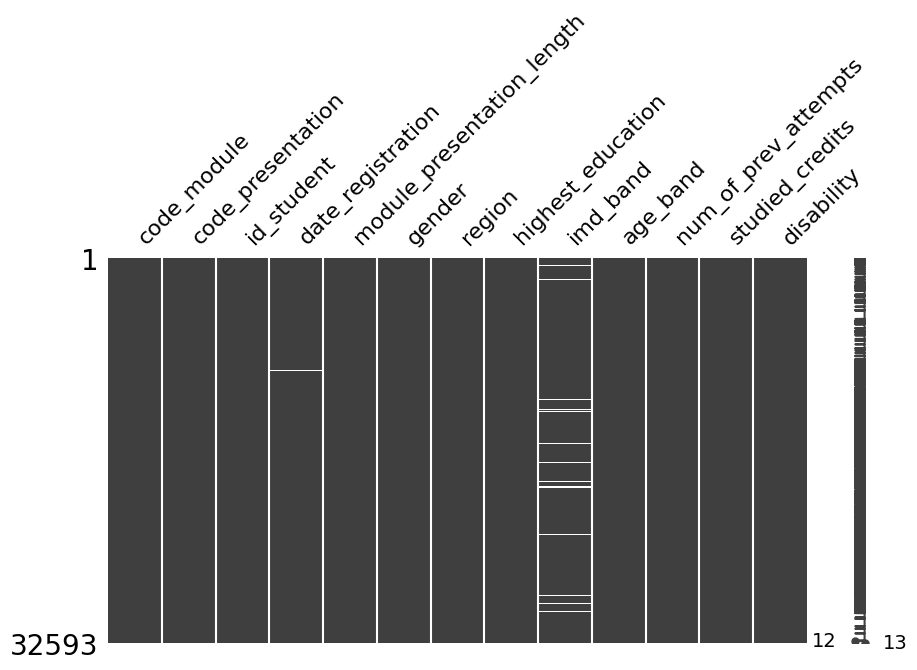

In [22]:
import missingno as mn
mn.matrix(regCoursesInfo, figsize=(10,5))

In [23]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(regCoursesInfo)
#profile

In [24]:
regCoursesInfo.shape

(32593, 13)

#генерация признак-1-2


In [25]:
def findDiffValues(df1: pd.DataFrame, df2: pd.DataFrame, col: str):
    '''
    Найти все значения df1.col, отсутствующие в df2.col
    '''
    # Вытащите все уникальные значения col
    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    # Сравните два списка
    # (a) Найдите, какие значения отличаются
    diff = set(df1_IDs).difference(set(df2_IDs))
    # (b) осчитайте, сколько разных
    numberDiff = len(diff)

    print("Значения из df1 не в df2: " + str(diff))
    print("Количество пропущенных значений: " + str(numberDiff))

    return diff

In [26]:
agged_stud_ass = results.groupby('id_student').agg(mean_date_submitted=('date_submitted', 'mean'))
display(agged_stud_ass.shape)
agged_stud_ass.tail(2)

(23369, 1)

,mean_date_submitted
id_student,
2698577,106.2
2698588,106.8


In [27]:
results_cor = results.copy()
results_cor.shape

(173912, 4)

In [28]:
exams_nan = sorted(list(findDiffValues(ass, results, 'id_assessment')))

Значения из df1 не в df2: {30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911}
Количество пропущенных значений: 18


In [29]:
for i in exams_nan: # Проходим по списку недостающих значений
    prev = i-1
    changed = results_cor[results_cor['id_assessment']==prev] # Считываем все строки с предыдущим значением
    changed.loc[:,'id_assessment'].replace(prev, i, inplace=True) # Заменяем на текущее
    results_cor = pd.concat([results_cor, changed]) # Присоединяем к датафрейму

In [30]:
dataset=regCoursesInfo.merge(agged_stud_ass, on =['id_student'], how = 'left')

In [31]:
res_count = results_cor.groupby('id_student')['id_assessment'].count().reset_index()
res_count = res_count.rename(columns={'id_assessment':'res_count'})
res_count.head(2)

,id_student,res_count
0,6516,6
1,8462,7


In [32]:
dataset = pd.merge(dataset, res_count, on='id_student', how='left')
print(dataset.shape)
dataset.head(2)

(32593, 15)


,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted,res_count
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,112.4,6.0
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,114.2,6.0


In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  object 
 3   date_registration           32548 non-null  float64
 4   module_presentation_length  32593 non-null  int64  
 5   gender                      32593 non-null  object 
 6   region                      32593 non-null  object 
 7   highest_education           32593 non-null  object 
 8   imd_band                    31482 non-null  object 
 9   age_band                    32593 non-null  object 
 10  num_of_prev_attempts        32593 non-null  int64  
 11  studied_credits             32593 non-null  int64  
 12  disability                  32593 non-null  object 
 13  mean_date_submitted         267

#генерация признак-3

In [34]:
student_ages = info[['id_student', 'age_band']].groupby(['id_student']).count().reset_index()
age= vle[["id_student"]].merge(student_ages, on = ['id_student'], how = 'left')

In [35]:
group_4=age.groupby(['id_student'],as_index=False)["age_band"].sum()
group_4[:2]

,id_student,age_band
0,6516,662
1,8462,608


In [36]:

df = info.merge(vle, on = ['id_student','code_module','code_presentation'], how = 'left')
df=df.merge(reg, on = ['id_student','code_module','code_presentation'], how = 'left')
group_2=df.groupby(['code_module', 'code_presentation', 'id_student'],as_index=False)["date_registration"].sum()
group_2[:2]


,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-31164.0
1,AAA,2013J,28400,-22790.0


In [37]:
full=group_4.merge(group_2, on = ['id_student'], how = 'right')
full["optional"]=full.age_band+full.date_registration
full.drop("age_band",axis=1,inplace=True)
full.drop("date_registration",axis=1,inplace=True)
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_student         32593 non-null  int64  
 1   code_module        32593 non-null  object 
 2   code_presentation  32593 non-null  object 
 3   optional           29741 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ MB


In [38]:
dataset=dataset.merge(full, on = ['id_student','code_module','code_presentation'], how = 'left')

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  object 
 3   date_registration           32548 non-null  float64
 4   module_presentation_length  32593 non-null  int64  
 5   gender                      32593 non-null  object 
 6   region                      32593 non-null  object 
 7   highest_education           32593 non-null  object 
 8   imd_band                    31482 non-null  object 
 9   age_band                    32593 non-null  object 
 10  num_of_prev_attempts        32593 non-null  int64  
 11  studied_credits             32593 non-null  int64  
 12  disability                  32593 non-null  object 
 13  mean_date_submitted         267

#генерация признак-4

In [40]:
reg.date_registration.value_counts()

-22.0     1034
-29.0      982
-24.0      741
-25.0      730
-23.0      729
          ... 
-270.0       1
-258.0       1
-229.0       1
-320.0       1
 110.0       1
Name: date_registration, Length: 332, dtype: int64

In [41]:
reg['register_days'] = (np.where(pd.isnull(reg.date_registration), 1034,
                                          reg.date_registration)).astype(int)
studentRegDays_df = reg[['id_student', 'register_days',]].groupby(['id_student']).mean().reset_index()

In [42]:
studentRegDays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28785 entries, 0 to 28784
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_student     28785 non-null  int64  
 1   register_days  28785 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 449.9 KB


In [43]:
group3=vle.merge(studentRegDays_df, on = ['id_student'], how = 'left')

In [44]:
new=group3.groupby(['code_module', 'code_presentation', 'id_student'],as_index=False)["register_days"].sum()
dataset=dataset.merge(new, on = ['id_student','code_module','code_presentation'], how = 'left')

In [45]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  object 
 3   date_registration           32548 non-null  float64
 4   module_presentation_length  32593 non-null  int64  
 5   gender                      32593 non-null  object 
 6   region                      32593 non-null  object 
 7   highest_education           32593 non-null  object 
 8   imd_band                    31482 non-null  object 
 9   age_band                    32593 non-null  object 
 10  num_of_prev_attempts        32593 non-null  int64  
 11  studied_credits             32593 non-null  int64  
 12  disability                  32593 non-null  object 
 13  mean_date_submitted         267

#генерация признак-5


In [46]:
genero = info[['id_student', 'gender']].drop_duplicates().groupby('gender').\
    agg({'id_student':'count'}).reset_index().\
    rename(columns={"gender": "Genero",'id_student': 'count'})

genero['Percentual'] = genero.apply(lambda x: round(100 * (x['count'] / genero['count'].sum()),2), axis=1)

In [47]:
genero

,Genero,count,Percentual
0,F,13739,47.73
1,M,15046,52.27


In [48]:
genero1 = info[['id_student', 'gender']].groupby('id_student')["gender"].count().reset_index()
genero1[:5]

,id_student,gender
0,3733,1
1,6516,1
2,8462,2
3,11391,1
4,23629,1


In [49]:
df = genero1.merge(vle, on=['id_student'],how = 'right')
group_3=df.groupby(['code_module', 'code_presentation', 'id_student'],as_index=False)["gender"].sum()
group_3[:2]
display(group_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   code_module        29228 non-null  object
 1   code_presentation  29228 non-null  object
 2   id_student         29228 non-null  int64 
 3   gender             29228 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 913.5+ KB


None

In [50]:
dataset=dataset.merge(group_3, on = ['id_student','code_module','code_presentation'], how = 'left')

In [51]:
new_df=dataset.copy()
#new_df=filling_missing_values(new_df)

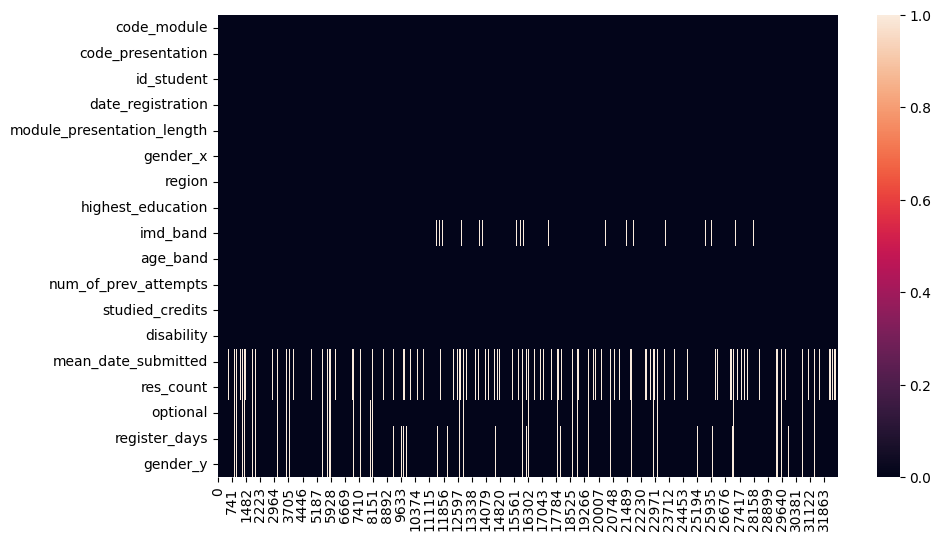

In [52]:
plt.figure(figsize=(10,6))
sns.heatmap(new_df.isna().transpose());

In [53]:
new_df.drop("date_registration",axis=1,inplace=True)
new_df.drop("module_presentation_length",axis=1,inplace=True)
new_df.drop("num_of_prev_attempts",axis=1,inplace=True)
new_df.drop("studied_credits",axis=1,inplace=True)
new_df.drop("gender_x",axis=1,inplace=True)



In [54]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  object 
 3   region               32593 non-null  object 
 4   highest_education    32593 non-null  object 
 5   imd_band             31482 non-null  object 
 6   age_band             32593 non-null  object 
 7   disability           32593 non-null  object 
 8   mean_date_submitted  26746 non-null  float64
 9   res_count            26746 non-null  float64
 10  optional             29741 non-null  float64
 11  register_days        29228 non-null  float64
 12  gender_y             29228 non-null  float64
dtypes: float64(5), object(8)
memory usage: 4.5+ MB


# Выделение тренировочной и тестовой выборки

Список студентов, соответсвующих модулей и презентаций (разные студенты могут сдавать разные модули)

In [55]:
Train_Who = pd.read_csv('/content/Train_Who.csv')
Test_Who = pd.read_csv('/content/Test_Who.csv')

In [56]:
Train_Who.shape

(26074, 4)

In [57]:
Train_Who.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26074 entries, 0 to 26073
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 26074 non-null  int64 
 1   id_student         26074 non-null  int64 
 2   code_module        26074 non-null  object
 3   code_presentation  26074 non-null  object
dtypes: int64(2), object(2)
memory usage: 814.9+ KB


А вот тут Left Join по всему содержимому `Train_Who`

Потому что мы не хотим ничего упустить оттуда

In [58]:
Train_Who

,ID,id_student,code_module,code_presentation
0,0,464685,DDD,2014B
1,1,606593,DDD,2013J
2,2,1674799,CCC,2014J
3,3,195246,FFF,2014J
4,4,582080,FFF,2013J
...,...,...,...,...
26069,26069,588477,AAA,2014J
26070,26070,653826,BBB,2014J
26071,26071,126411,BBB,2013B
26072,26072,547448,DDD,2013J


In [59]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Train = pd.merge(Train_Who, new_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Train.index = Train.ID
# удаляем как столбец, ибо зачем
Train.drop(columns = ['ID'], inplace = True)
Train.tail(2)

,id_student,code_module,code_presentation,region,highest_education,imd_band,age_band,disability,mean_date_submitted,res_count,optional,register_days,gender_y
ID,,,,,,,,,,,,,
26072,547448,DDD,2013J,South Region,Lower Than A Level,90-100%,35-55,N,123.714286,7.0,-121296.0,-122018.0,722.0
26073,596855,CCC,2014J,South West Region,Lower Than A Level,60-70%,0-35,N,32.000000,1.0,-364.0,-508.0,8.0


In [60]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_student           26074 non-null  object 
 1   code_module          26074 non-null  object 
 2   code_presentation    26074 non-null  object 
 3   region               26074 non-null  object 
 4   highest_education    26074 non-null  object 
 5   imd_band             25187 non-null  object 
 6   age_band             26074 non-null  object 
 7   disability           26074 non-null  object 
 8   mean_date_submitted  21357 non-null  float64
 9   res_count            21357 non-null  float64
 10  optional             23783 non-null  float64
 11  register_days        23364 non-null  float64
 12  gender_y             23364 non-null  float64
dtypes: float64(5), object(8)
memory usage: 2.8+ MB


In [61]:
def filling_missing_values(data):
  num_cols =data.select_dtypes(include=np.number).columns
  cat_cols = data.columns[data.dtypes == 'object']
  print(print("size_of_num_and_cat_cols" ), len(num_cols),len(cat_cols))
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
  #print("cat_cols_missing_percentage")
  #display(missing_value_df.loc[cat_cols].sort_values(ascending=False,by="percent_missing")[:10])

  miss_cat=missing_value_df.loc[cat_cols][percent_missing!=0]
  miss_num=missing_value_df.loc[num_cols][percent_missing!=0]
  print("filling_columns_cat")
  display(miss_cat)
  print("filling_columns_num")
  display(miss_num)
  #strategy_for_categorial_feature
  imputer = SimpleImputer(strategy='most_frequent',missing_values=np.nan)
  data[miss_cat.index]=imputer.fit_transform(data[miss_cat.index])
  #strategy_for_numerical_feature
  imputer=KNNImputer(n_neighbors=5)
  data[miss_num.index]=imputer.fit_transform(data[miss_num.index])
  #for column in num_cols:
    #data[column]=data[column].fillna(0)
  return data

In [62]:
Train=filling_missing_values(Train)

size_of_num_and_cat_cols
None 5 8
filling_columns_cat


,column_name,percent_missing
imd_band,imd_band,3.401856


filling_columns_num


,column_name,percent_missing
mean_date_submitted,mean_date_submitted,18.090818
res_count,res_count,18.090818
optional,optional,8.786531
register_days,register_days,10.393495
gender_y,gender_y,10.393495


аналогично для тестовой выборки

In [63]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Test = pd.merge(Test_Who, new_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Test.index = Test.ID
# удаляем как столбец, ибо зачем
Test.drop(columns = ['ID'], inplace = True)
Test.head(2)

,id_student,code_module,code_presentation,region,highest_education,imd_band,age_band,disability,mean_date_submitted,res_count,optional,register_days,gender_y
ID,,,,,,,,,,,,,
26074,2588655,DDD,2014J,Scotland,Lower Than A Level,50-60%,0-35,N,85.777778,9.0,-4148.0,-3172.5,94.0
26075,543628,CCC,2014B,North Western Region,HE Qualification,0-10%,35-55,N,NaN,NaN,NaN,NaN,NaN


In [64]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 26074 to 32592
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_student           6519 non-null   object 
 1   code_module          6519 non-null   object 
 2   code_presentation    6519 non-null   object 
 3   region               6519 non-null   object 
 4   highest_education    6519 non-null   object 
 5   imd_band             6295 non-null   object 
 6   age_band             6519 non-null   object 
 7   disability           6519 non-null   object 
 8   mean_date_submitted  5389 non-null   float64
 9   res_count            5389 non-null   float64
 10  optional             5958 non-null   float64
 11  register_days        5864 non-null   float64
 12  gender_y             5864 non-null   float64
dtypes: float64(5), object(8)
memory usage: 713.0+ KB


In [65]:
Test=filling_missing_values(Test)

size_of_num_and_cat_cols
None 5 8
filling_columns_cat


,column_name,percent_missing
imd_band,imd_band,3.43611


filling_columns_num


,column_name,percent_missing
mean_date_submitted,mean_date_submitted,17.333947
res_count,res_count,17.333947
optional,optional,8.605614
register_days,register_days,10.047553
gender_y,gender_y,10.047553


In [66]:
Target = pd.read_csv('/content/Train_Target_reg.csv', index_col = 'ID')
Target.describe()

,weighted_score
count,26074.000000
mean,52.495302
std,29.724236
min,0.000000
25%,22.000000
50%,60.500000
75%,77.400000
max,100.000000


In [67]:


df=pd.concat([Train,Target],axis=1)
display(df.head(2))

num_cols =df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

df=df[num_cols]

corr_df=pd.DataFrame(df.corr()["weighted_score"].sort_values(ascending=False)[:15])
corr_df.style.background_gradient(cmap='Blues')

,id_student,code_module,code_presentation,region,highest_education,imd_band,age_band,disability,mean_date_submitted,res_count,optional,register_days,gender_y,weighted_score
ID,,,,,,,,,,,,,,
0,464685,DDD,2014B,East Anglian Region,A Level or Equivalent,50-60%,0-35,N,123.285714,7.0,-20825.0,-21420.0,595.0,64.9125
1,606593,DDD,2013J,Scotland,A Level or Equivalent,20-30%,0-35,N,55.333333,3.0,-10137.0,-10464.0,327.0,14.8625


We have 6 numeric columns: mean_date_submitted, res_count, optional, register_days, gender_y, weighted_score
And 8 categorical columns: id_student, code_module, code_presentation, region, highest_education, imd_band, age_band, disability


,weighted_score
weighted_score,1.000000
mean_date_submitted,0.568801
res_count,0.475302
gender_y,0.377719
optional,-0.303395
register_days,-0.310118


#KMEANS for liniarity


In [68]:
df1=df[Train.select_dtypes(include=np.number).columns]
df1['region']=Train["region"]
#df1['code']=Train["code_presentation"]
df1[:2]

,mean_date_submitted,res_count,optional,register_days,gender_y,region
ID,,,,,,
0,123.285714,7.0,-20825.0,-21420.0,595.0,East Anglian Region
1,55.333333,3.0,-10137.0,-10464.0,327.0,Scotland


In [69]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.4 MB/s eta 0:00:00


In [70]:
num_cols =df1.select_dtypes(include=np.number).columns
cat_cols = df1.columns[df1.dtypes == 'object']
from category_encoders import TargetEncoder
numerical_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('scaler',   StandardScaler())
])
categorical_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
   #('encoder', OrdinalEncoder( ))
   #('encoder', TargetEncoder( ))
])
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

new_df=pd.DataFrame(preprocessors.fit_transform(df1))

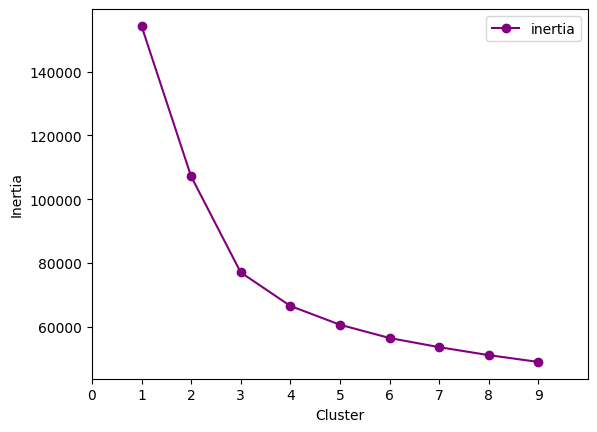

In [71]:
# create and fit a range of models:
from sklearn.cluster import KMeans
km_list = list()
for clust in range(1, 10):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(new_df)
    km_list.append(pd.Series({'clusters': clust,
                             'inertia':km.inertia_,
                             'model':km}))
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o', ls='-', color='purple')
ax.set_xticks(range(0, 10, 1))
ax.set_xlim(0,10)
ax.set(xlabel='Cluster', ylabel='Inertia');



In [72]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,random_state=42)
kmeans.fit(new_df)

#df['cust_type'] = kmeans.predict(df[features])
df['cust_type'] = kmeans.labels_
corr_df=pd.DataFrame(df.corr()["weighted_score"].sort_values(ascending=False)[:15])
corr_df.style.background_gradient(cmap='Blues')

,weighted_score
weighted_score,1.000000
mean_date_submitted,0.568801
res_count,0.475302
gender_y,0.377719
cust_type,0.337866
optional,-0.303395
register_days,-0.310118


In [73]:
kmeans = KMeans(n_clusters=2, random_state=0)


# YOUR CODE HERE: Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(new_df)


# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X_cd[:2]

,Centroid_0,Centroid_1
0,2.869089,1.482527
1,4.151646,1.478782


In [74]:
#df=df.join(X_cd)
new=pd.concat([df,X_cd],axis=1)

corr_df=pd.DataFrame(new.corr()["weighted_score"].sort_values(ascending=False)[:15])
corr_df.style.background_gradient(cmap='Blues')

,weighted_score
weighted_score,1.000000
mean_date_submitted,0.568801
res_count,0.475302
gender_y,0.377719
cust_type,0.337866
Centroid_1,0.213687
optional,-0.303395
register_days,-0.310118
Centroid_0,-0.449586


#plot results

In [76]:
def plot_predict(y_test,predicted):
  A = np.array(y_test).reshape(-1, 1)
  B = predicted.reshape(-1, 1)

  print(type(predicted))
  print(type(y_test))
  plt.rcParams['figure.figsize'] = 16,5
  plt.figure()
  plt.plot(A[-100:], label="Real")
  plt.plot(B[-100:], label="Predicted")
  plt.legend()
  plt.title("score: real vs predicted")
  plt.ylabel("score")
  plt.xticks(())
  rmse = np.sqrt(mean_squared_error(y_test, predicted))

  print('RMSE: ',rmse)

  print('Variance score: %.2f' % r2_score(y_test, predicted))
  plt.show()

#ESTIMATOR FOR PIPELINE

In [77]:

from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LinearRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)



pipeline = Pipeline(steps=[
    ('model',  ClfSwitcher())
])


# Попытаемся слепить предсказание на коленке

Наверное использовать id студента - так себе вариант

Значит - удалим

In [78]:
Train.drop(columns = ['id_student'], inplace = True)
Test.drop(columns = ['id_student'], inplace = True)

In [79]:
from scipy.stats import norm, skew
import scipy.stats as stats
def diagnostic_plots(df, variable):
    plt.figure(figsize=(5,2))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

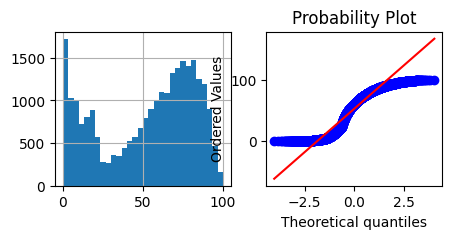

In [80]:
diagnostic_plots(Target,"weighted_score")


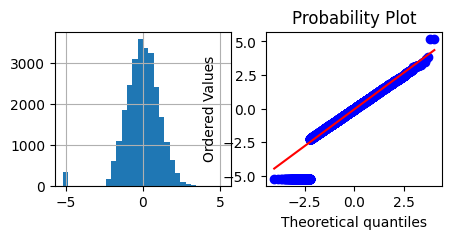

In [81]:
from sklearn.preprocessing import QuantileTransformer
quantile = QuantileTransformer(output_distribution='normal')
data_trans = quantile.fit_transform(Target)

diagnostic_plots(pd.DataFrame(data_trans),0)

## наш старый друг Pipeline

In [82]:
from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scki-kit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

Создаем объект `Pipeline`

На вход ему подаем список из того, что мы хотим объединить в формате
* строка- название (даем имя Объекту)
* и сам объект (с заданными аргументами, если необходимо)

Сначала создадим отдельно Pipeline для числовых данных (вставление пропусков + нормализация)

In [83]:
Train.columns

Index(['code_module', 'code_presentation', 'region', 'highest_education',
       'imd_band', 'age_band', 'disability', 'mean_date_submitted',
       'res_count', 'optional', 'register_days', 'gender_y'],
      dtype='object')

In [84]:
num_cols =Train.select_dtypes(include=np.number).columns
cat_cols = Train.columns[Train.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 5 numeric columns: mean_date_submitted, res_count, optional, register_days, gender_y
And 7 categorical columns: code_module, code_presentation, region, highest_education, imd_band, age_band, disability


In [85]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import QuantileTransformer

def preprocess(X,test,y,degree=1):


  numerical_pipe = Pipeline([
      ('poly', PolynomialFeatures(degree)),
      ("quantil",QuantileTransformer(output_distribution='normal')),
      ('scaler',   StandardScaler())
  ])

  categorical_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
    #('encoder', OrdinalEncoder( ))
     #('encoder', TargetEncoder( ))
  ])

  preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
  ])

  new_X=preprocessors.fit_transform(X,y) # преобразуем  тренировочные данные
  new_test = preprocessors.transform(test) # преобразуем  тестовые данные

  return new_X , new_test


In [86]:
Train_,Test_=preprocess(X=Train,test=Test,y=Target,degree=4)

In [87]:
Train_.shape,Test_.shape

((26074, 169), (6519, 169))

#fuction cross_validation and plot

In [88]:
def results(X_train,y_train,X_val,y_val,estimator):
  best_=estimator
  best_.fit(X_train, y_train)
# предсказываем на тестовых данных
  y_predict=best_.predict(X_val)

  scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}

# используем функцию кросс-валидации

  scores = cross_validate(best_, # какую модель тестируем
                        X_train, y_train, # на каких данных
                      scoring=scoring,  #на каких метриках
                      # как разбиваем данные при кросс-валидации
                      cv=ShuffleSplit(n_splits=3, random_state=42),return_train_score=True)


  print('Результаты Кросс-валидации')
  DF_cv_forest = pd.DataFrame(scores)
  display(DF_cv_forest)


  print('Ошибка на тестовых данных')
  print('MSE: %.4f' % mean_squared_error(y_val,y_predict))
  print('RMSE: %.4f' % mean_squared_error(y_val,y_predict,squared=False))

  print('R2 : %.4f' %  r2_score(y_val,y_predict))
  plot_predict(y_val,y_predict)

#function train_test_split

In [89]:
def split(X,y):
  X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.2, random_state=42)

  print('Training Features Shape:', X_train.shape)
  print('Training Labels Shape:', y_train.shape)
  print('Testing Features Shape:', X_val.shape)
  print('Testing Labels Shape:', y_val.shape)
  return X_train,X_val,y_train,y_val

In [90]:
X_train,X_val,y_train,y_val=split(Train_,Target)

Training Features Shape: (20859, 169)
Training Labels Shape: (20859, 1)
Testing Features Shape: (5215, 169)
Testing Labels Shape: (5215, 1)


#Feature_selection

In [91]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import StratifiedKFold # при кросс-валидации разбиваем данные в пропорции целевой метки

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

sel_= SelectFromModel(Lasso(alpha=0.005,random_state=0))
# train Lasso model and select features
sel_.fit(X_train,y_train)
# let's print the number of total and selected features


SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))
# let's print the number of total and selected features
selected_feats = pd.DataFrame(X_train).columns[(sel_.get_support())]
# let's print some stats
print('Total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))


Total features: 169
selected features: 149
features with coefficients shrank to zero: 20


In [92]:

X_train=pd.DataFrame(X_train).iloc[:,selected_feats]
X_test=pd.DataFrame(Test_).iloc[:,selected_feats]
X_val=pd.DataFrame(X_val).iloc[:,selected_feats]

#regression -degree-4







In [93]:
parameters_reg = [
    {
        'model': (Ridge(),),
        'model__alpha': np.logspace(-1, 2, 10),
        'model__fit_intercept':[True,False]
    },
    {
        'model': ( Lasso(),),
        'model__alpha': np.logspace(-1, 2, 10),
        'model__fit_intercept':[True,False]
    }
]

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters_reg,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 40 candidates, totalling 120 fits


Результаты Кросс-валидации


,fit_time,score_time,test_R2,train_R2,test_-MSE,train_-MSE,test_-MAE,train_-MAE,test_Max,train_Max
0,0.067091,0.030555,0.476421,0.484282,-464.365194,-454.104956,-16.684880,-16.588735,-122.882329,-88.519820
1,0.095286,0.010950,0.482770,0.484259,-454.931046,-454.543727,-16.717198,-16.580047,-89.208810,-82.940250
2,0.109863,0.011124,0.490453,0.483147,-449.018725,-455.426444,-16.504756,-16.615281,-79.204626,-85.249465


Ошибка на тестовых данных
MSE: 466.0072
RMSE: 21.5872
R2 : 0.4780
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
RMSE:  21.587201067090987
Variance score: 0.48


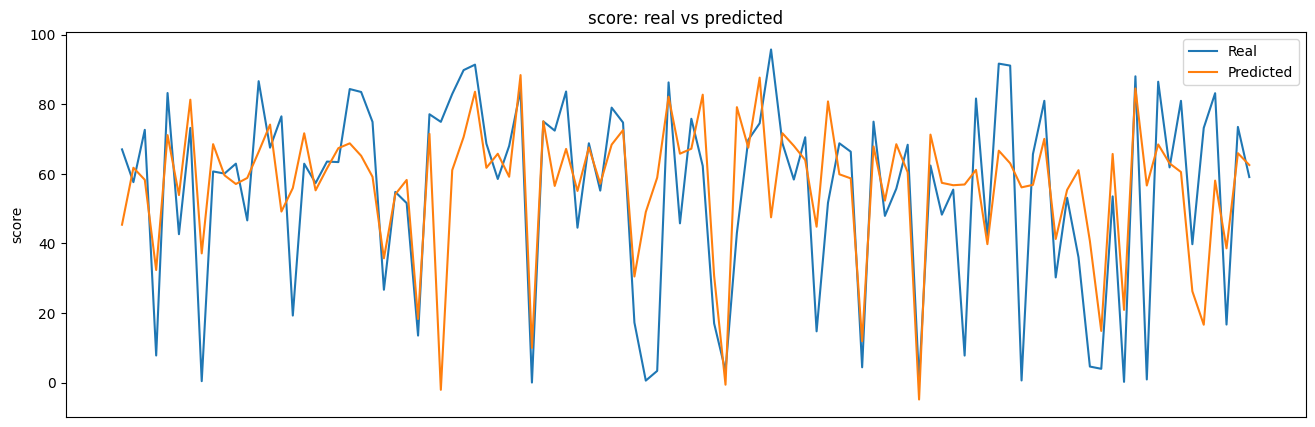

In [94]:
results( X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,estimator=rf_random.best_estimator_)

In [95]:
base_predictions = rf_random.predict(X_val)

In [96]:
rf_residuals = y_train - rf_random.predict(X_train)
rf_residuals.shape

(20859, 1)

In [97]:
from sklearn.ensemble import  RandomForestRegressor
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(1, 100, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 40, num = 41)]
#max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 60, num = 15)]
# Method of selecting samples for training each tree
bootstrap = [True]


parameters = [
  {
        'model': (RandomForestRegressor(),),
        'model__n_estimators': n_estimators,
        'model__max_features': max_features,
        'model__max_depth': max_depth,
        'model__min_samples_leaf': min_samples_leaf,
        'model__bootstrap': bootstrap,
    }
]

In [98]:

# search across 100 different combinations, and use all available cores
rf_random_1 = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random_1.fit(X_train, rf_residuals);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [99]:
rf_residual_predictions = rf_random_1.predict(X_val)

# Combine base predictions and RF predictions to get final predictions
final_predictions = base_predictions + rf_residual_predictions.reshape(-1,1)



In [100]:
rf_residual_predictions.reshape(-1,1)


array([[-4.00612232],
       [18.51271442],
       [ 0.32722419],
       ...,
       [ 0.53374603],
       [11.36240188],
       [10.90895312]])

In [101]:
base_predictions

array([[29.71365669],
       [43.53182681],
       [46.10977366],
       ...,
       [38.56953932],
       [65.91043132],
       [62.50864352]])

In [102]:
final_predictions

array([[25.70753437],
       [62.04454123],
       [46.43699785],
       ...,
       [39.10328535],
       [77.2728332 ],
       [73.41759664]])

In [103]:
final_predictions.shape

(5215, 1)

In [104]:
y_val.shape

(5215, 1)

In [105]:
rf_random_1.best_estimator_

Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=19, max_features='auto',
                                       min_samples_leaf=9, n_estimators=82))])

In [106]:
rf_residuals.shape,X_train.shape

((20859, 1), (20859, 149))

In [107]:
y_val.shape,final_predictions.shape

((5215, 1), (5215, 1))

Ошибка на тестовых данных
MSE: 359.5067
RMSE: 18.9607
R2 : 0.5973
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
RMSE:  18.9606607693986
Variance score: 0.60


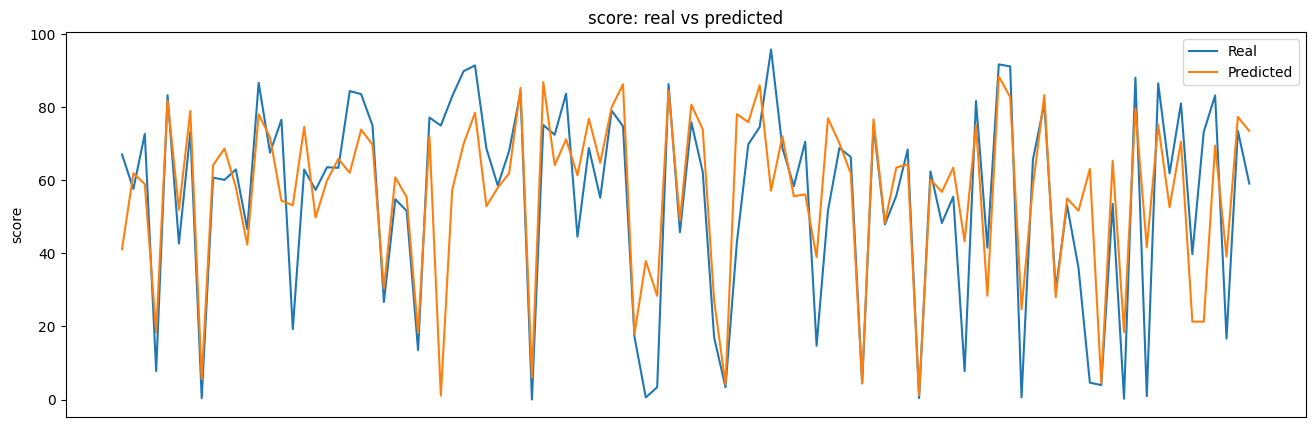

In [108]:
print('Ошибка на тестовых данных')
print('MSE: %.4f' % mean_squared_error(y_val,final_predictions))
print('RMSE: %.4f' % mean_squared_error(y_val,final_predictions,squared=False))

print('R2 : %.4f' %  r2_score(y_val,final_predictions))
plot_predict(y_val,final_predictions)

In [109]:
base_predictions_test = rf_random.predict(X_test)

In [110]:
rf_residual_predictions_test = rf_random_1.predict(X_test)
# Combine base predictions and RF predictions to get final predictions
final_predictions_test = base_predictions_test + rf_residual_predictions_test.reshape(-1,1)

In [111]:
Submission = pd.read_csv('/content/Submission_reg.csv', index_col = 'ID')

In [112]:
Submission['weighted_score'] = final_predictions_test

In [113]:
Submission['weighted_score'][:10]

ID
26074    33.022069
26075    27.496363
26076    38.492003
26077     4.876844
26078    45.597002
26079    75.054842
26080    77.286517
26081    25.523066
26082    75.605222
26083    55.511534
Name: weighted_score, dtype: float64

In [114]:
Submission.to_csv('/content/My_Submission_reg_final_2.csv',index=True) # если хотим чтобы и индексы сохранились - пишем index = True

In [115]:
#                                ↓ соревнование         ↓ название файла     ↓ комментарий
!kaggle competitions submit -c urfuaieng2022reg2 -f My_Submission_reg_final_2.csv -m " regression test"

100% 154k/154k [00:00<00:00, 575kB/s] 
Successfully submitted to UrFU_AI_Eng_2022_Reg_2